In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d

import utils as ut
import props as p
from importlib import reload
reload(ut)
reload(p)
TIM = p.TIM
GAL = p.AstroDeep

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h

lCII = 157.74 * u.micron # Cooksy et al. 1986
nuCII = lCII.to(u.Hz, equivalencies=u.spectral()).value

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 0.6
L0 = 8.3 * 10**6 * u.Lsun * u.yr / u.Msun
# TODO(shubh): figure out what this value is and how it comes in, and units

colors = ['black', 'purple', 'blue', 'gold', 'red', 'black']

In [2]:
# define our bins, 0th AND last bin is the full range, one SW and LW properties
bins = [
    ut.zBin(TIM.SW.zmin, TIM.LW.zmax), # full TIM range
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
    ut.zBin(TIM.SW.zmin, TIM.LW.zmax), # full TIM range
]

bin_zs = [b.center.value for b in bins]

bands = ['SW', 'SW', 'SW', 'LW', 'LW', 'LW'] 
# TODO(shubh): see whether LW/SW for the full experiment, or a different medial setup

print("TIM bins:")
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

TIM bins:
z in [0.521, 1.663]
z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]
z in [0.521, 1.663]


In [3]:
# TODO: see whether LW/SW for the full experiment, or a different medial setup
LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

for lsb in LSbins:
    print(lsb.cell_noise(TIM.time))

1966939156005.4478 Jy2 Mpc3 / s2
703036143029.9122 Jy2 Mpc3 / s2
1331424515709.3003 Jy2 Mpc3 / s2
635017875208.5846 Jy2 Mpc3 / s2
972729789399.4269 Jy2 Mpc3 / s2
557725693437.0326 Jy2 Mpc3 / s2


In [4]:
# above different from Juzz because [CII] freq and bug in area_scan, 
# maybe also because he uses wrong "azScan" field size

In [5]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

print(len(k_xyz_modes))
[print(kxyzs.shape) for kxyzs in k_xyz_modes]

6
(3, 20, 102, 115)
(3, 20, 102, 39)
(3, 20, 102, 29)
(3, 15, 77, 39)
(3, 15, 77, 30)
(3, 15, 77, 153)


[None, None, None, None, None, None]

In [6]:
# above different from Juzz because he uses wrong "azScan" field size
# a lot is going to be different now, because this is a major change
# refer to CII_Xcorr_shubh.ipynb instead now.

In [7]:
# these arrays are similarly structured:
# arr[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]

# TODO: why linearly spaced?
# k_bins = [np.linspace(k_min, np.max(km), num=num_kbin+1) \
#     for k_min, km, num_kbin in zip(k_mins, k_mags, num_kbins)]
# k_bins = [np.logspace(np.log10(k_min), np.log10(np.max(km)), num=num_kbin+1) \
#     for k_min, km, num_kbin in zip(k_mins, k_mags, num_kbins)]

num_kbins

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_5762/2023157695.py:13: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


[18, 16, 15, 15, 14, 17]

In [8]:
k_props[0].shape

(3, 20, 102, 115)

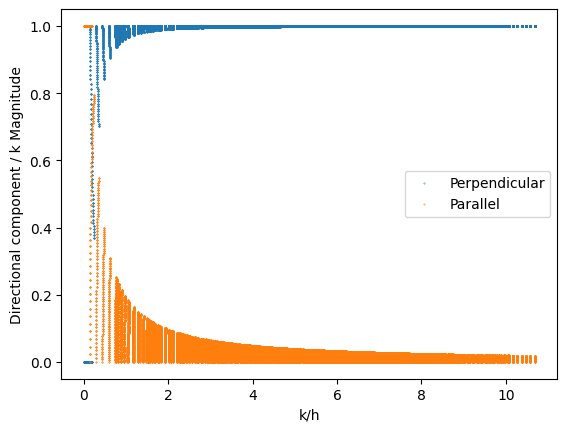

In [9]:
# making a plot for full TIM survey
plt.figure()
plt.plot(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='.', linestyle='None', markersize=.6, label = 'Perpendicular')
#plt.plot(k1Mag.flatten(), ky1Props.flatten(), marker='.', linestyle='None')
plt.plot(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', markersize=.6, label = 'Parallel')
plt.xlabel('k/h')
plt.ylabel('Directional component / k Magnitude')
plt.legend()

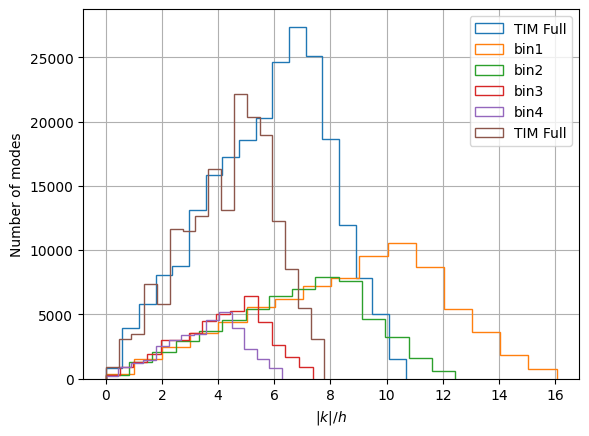

In [10]:
plt.figure()
for i in range(len(k_mags)):
    if i == 0 or i == 5:
        plt.hist(k_mags[i].flatten(), bins=num_kbins[i], alpha = 1, label = 'TIM Full', histtype='step')
    else:
        plt.hist(k_mags[i].flatten(), bins=num_kbins[i], alpha = 1, label = f'bin{i}', histtype='step')

plt.xlabel(r'$|k|/h$')
plt.ylabel('Number of modes')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [11]:
# resolution elements I assume
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

In [12]:
s_perps

[0.17662024934281542,
 0.11755244692217426,
 0.1516503189988713,
 0.24571221408768276,
 0.28908943552124405,
 0.2336968110693985]

In [13]:
# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

In [14]:
windows[0].shape

(20, 102, 115)

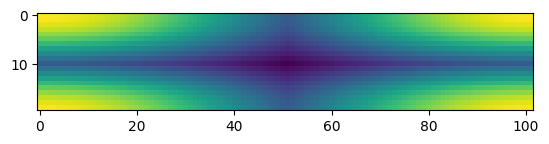

In [15]:
plt.figure()
plt.imshow(windows[0][:, :, 0])
plt.show()
plt.close()

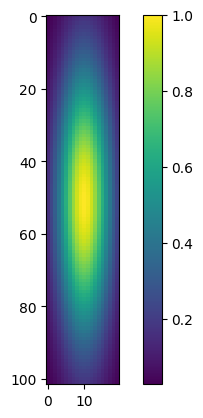

In [16]:
plt.figure()
plt.imshow(np.fft.fftshift(windows[0][:, :, 0]).T ** 2)
plt.colorbar()
plt.show()
plt.close()

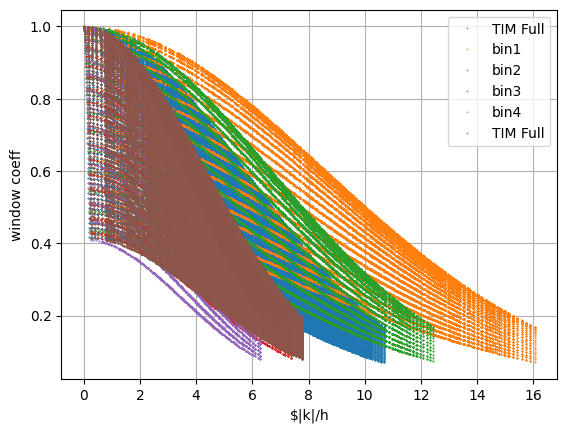

In [17]:
plt.figure()
for i in range(len(k_mags)):
    if i == 0 or i == 5:
        plt.plot(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
            linestyle='None', label = 'TIM Full', markersize=.6)
    else:
        plt.plot(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
            linestyle='None', label = 'bin'+str(i), markersize=.6)

plt.xlabel(r'$|k|/h')
plt.ylabel('window coeff')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [18]:
# window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
#                 for i in range(len(kb)-1)]) 
#         for win, km, kb in zip(windows, k_mags, k_bins)]

In [19]:
bin_zs

[1.0920502092050208,
 0.6435273234436414,
 0.8875998478508937,
 1.1728794218333967,
 1.4993660453911497,
 1.0920502092050208]

In [20]:
# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=True) 
# TODO: why not nonlinear?
# TODO: why not much higher kmax?

results = camb.get_results(pars)

Note: redshifts have been re-sorted (earliest first)


In [21]:
binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]
print(z_idxs)

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

[2, 0, 1, 3, 4, 2]


In [22]:
kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

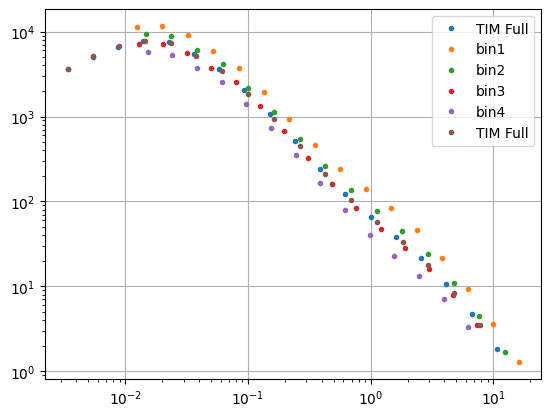

In [23]:
plt.figure()
for i in range(len(Pms)):
    if i == 0 or i == 5:
        plt.plot(Pms[i][0], Pms[i][1], label = 'TIM Full', linestyle='none', marker='.')
    else:
        plt.plot(Pms[i][0], Pms[i][1], label = 'bin'+str(i), linestyle='none', marker='.')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [24]:
3.38994999e-03 / 5.44490142e-03, 9.34911274e-02 / 1.50164449e-01 # log scale from CAMB

(0.622591618931459, 0.6225916188724536)

In [25]:
# TODO: something fishy here, the windowing bins are linspaced, 
# but the camb bins are logspaced, that is inconsistent!

In [26]:
Pms[0][0]

array([3.38994999e-03, 5.44490142e-03, 8.74554241e-03, 1.40469967e-02,
       2.25621358e-02, 3.62390612e-02, 5.82067924e-02, 9.34911274e-02,
       1.50164449e-01, 2.41192531e-01, 3.87400864e-01, 6.22239124e-01,
       9.99433825e-01, 1.60527992e+00, 2.57838343e+00, 4.14137189e+00,
       6.65182723e+00, 1.06840938e+01])

In [27]:
window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shubh/miniconda3/envs/lim/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


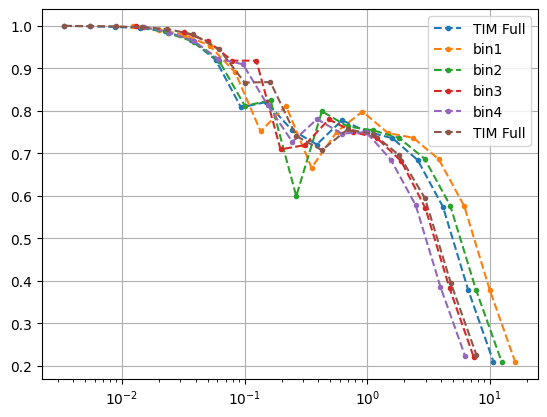

In [28]:
plt.figure()
for i in range(len(Pms)):
    if i == 0 or i == 5:
        plt.plot(Pms[i][0], window_avgs[i], label = 'TIM Full', linestyle='--', marker='.')
    else:
        plt.plot(Pms[i][0], window_avgs[i], label = 'bin'+str(i), linestyle='--', marker='.')

plt.xscale('log')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [35]:
sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([ut.Inu(sfrd, z, L0) for sfrd, z in zip(sfrds, bin_zs)])

In [38]:
x_shots

array([18.07619446, 34.31468615, 16.43992818, 18.2468663 ,  7.88958705,
       18.07619446])

In [39]:
fs = 0.897
# TODO: old code had this as an array, but then only used the last element
Igal, bCII, bstar = 1, 1, 3

x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
PxGs = [(bstar * Icii * Igal * Pm) + x_shot 
            for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]
num_modes = [np.histogram(km, kb)[0] for km, kb in zip(k_mags, kbin_edges)]

In [40]:
x_noise = [np.sqrt(lsb.cell_noise(TIM.time).value / (2 * n_gal * nm * w))
        for lsb, n_gal, nm, w in zip(LSbins, GAL.n_gals, num_modes, window_avgs)]
SNR_PxG = [PxG / xn for PxG, xn in zip(PxGs, x_noise)]

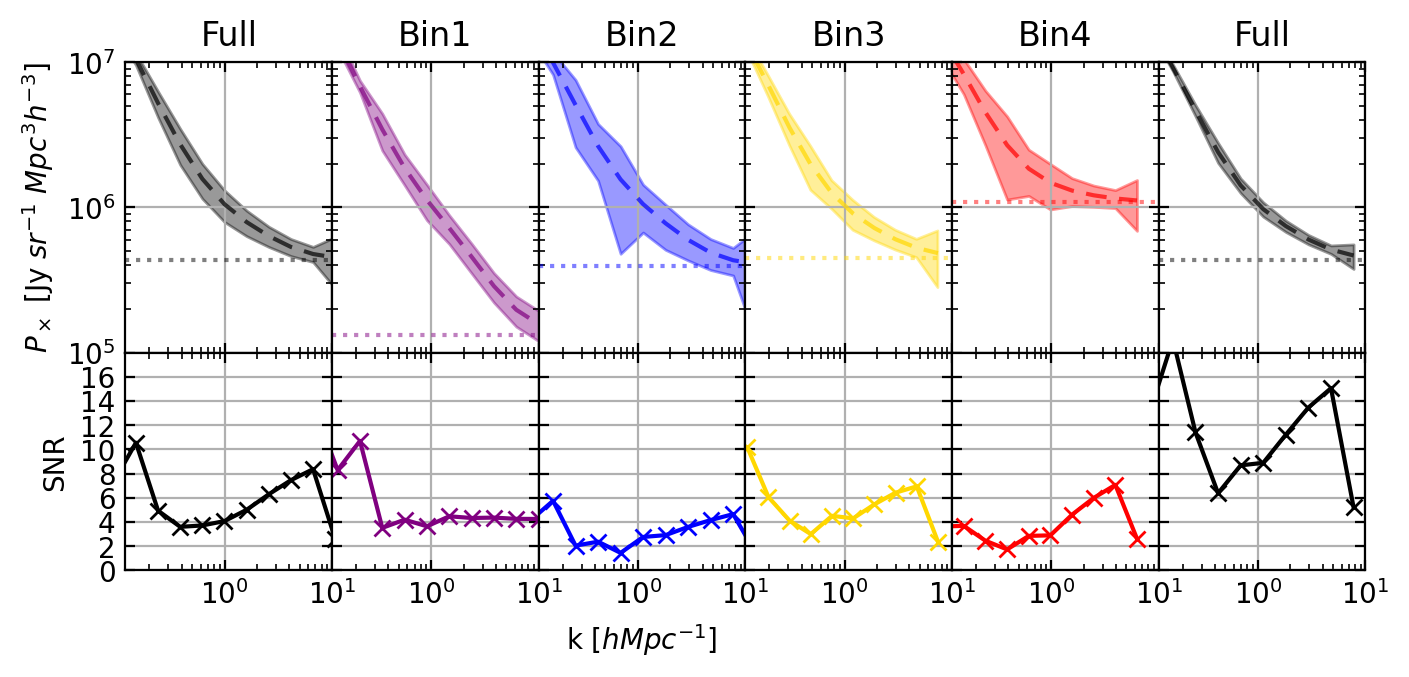

In [42]:
fig, (power, SNR) = plt.subplots(2, 6, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)
specline = '--'
fillAlpha = .4
lineAlpha = .7

for i, PxG in enumerate(PxGs):
    power[i].loglog(Pms[i][0], PxG, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PxG + x_noise[i],
                   PxG - x_noise[i], color = colors[i], alpha = fillAlpha)
    if ((i == 0) or (i == 5)):
        power[i].set_title('Full')
    else:
        power[i].set_title('Bin'+str(i))
        
    SNR[i].plot(Pms[i][0], SNR_PxG[i], color = colors[i], marker = 'x')
    power[i].grid()
    SNR[i].grid()
    SNR[i].set_yticks(np.arange(0, 18, 2.0))

power[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 10)

SNR[0].set_ylabel(r"SNR", size = 10)
power[0].set_xlim(1.2e-1, 0.1e2)

power[0].set_ylim(1e5, 1e7)
SNR[0].set_ylim(0,18)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()